# Lesson 5

Let's start where we left in Lesson 4:
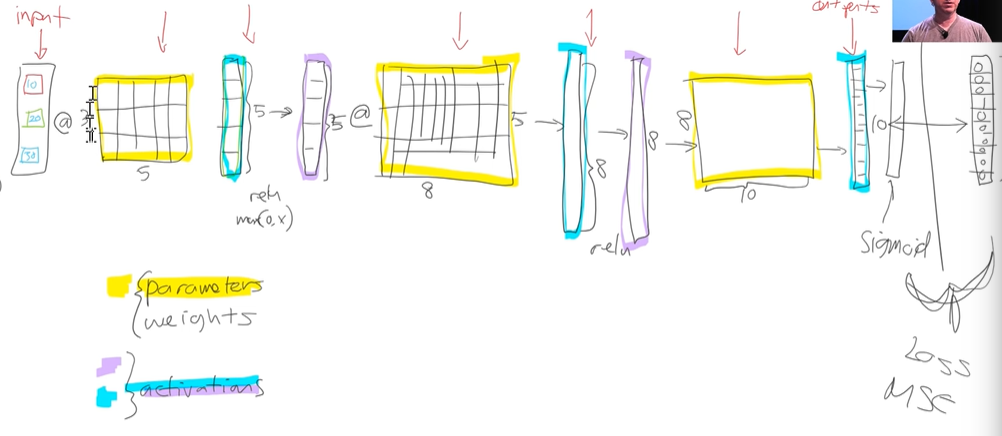

As we can see from above we have various layers in our NN.


There are only 2 types of layers:

- The ones that contain parameters: Parameters are the things that our model learns, here is where we use gradient descent to say:
   - **parameters -= lr * parameters.grad**
   Those parameters are used to be multiplied by input activations doing a matrix product.


- The ones that contain activations: This are calculated numbers. It's important to note that there are also activation funcitons which are funcitons applied to the result of matrix multiplications. Such activation functions can be sigmoid, relu, softmax, etc.

This combination of layers (matematical tools) has basically the mathematical property of the universal approximation theorem.

Finally we calculate our loss function, in this case the MSE and we calculate the gradients whit respect to our parameters/weights and we substract that from them. This process is called **backpropagation**. Wights -= lr * Weights.gradient

## Fine tunnning

What happens when we take a resnet34 and do transfered learning from image net.

Here the last layer has 1k columns since this will give us an ouput vector of (1000, 1) since Imagenet classifies an image out of 1k cateogries.


This is not our case since we dont's need such 1000 categories. So we throw away that part and we add 2 new weight matrices there with a RELU in betweeen. The first of those has some default configuration but the second one has as much columns as we need (data.c).


So the thing to notice here is that this 2 new layers are full of random numbers but the rest of the NN has already some values which are good at filtering images using convolutional layers.


The important thing here is that the first stage we are going to be training the 2 layers. This is the **freezed** training stage. Which means we are not backpropagatin the weights to the other layers.


After some epoch we now unfreeze and now we are going to train the whole network. However we have a very good sense that the last layers need more training than the first layers so what we do is to split our model into a few sections giving those sections different learing rates. This process is called discriminative learingin rates.


In fastai there are 3 ways to set up our learing rates:
- ...fit(1, N)
    - In this option what we are doing is training the whole NN with the same learning rate.
- ...fit(1, slice(N))
    - In this option the final layers will be trained using N and the rest will be traines using a learing rate of N/3.
- ...fit(1, slice(M, N))
    - In this option the first layers will get M, the last layers N and the other layers will get equally spread learning rates between those 2.
    
To be more precise, what's really happening is that we don't actually distribute the learingn rates between **each** layer but rather between **groups** of layers. As a note what by default, at least with a CNN, what happens is that we get 3 groups. The ones we add are 1 group and the other layers are split in 2 and those are the other 2 groups.

Also the N/3 thing will be further discussed in part 2 of the course.

## Collaborative filtering

As a note we don't call the operations matrix multiplications but rather linear functions that we add together which, in general are called **affine functions**. A Matrix multiplicaiotn is the most common kind of affine fuction (at least in DL).

As we remember in collaborative filtering we had 2 weights of matrices of weight (u X 5) (5 X i) so that we have a resulting matrix of (u x i) which are the predictions for what rating will the uth user will give the ith movie.

### Embedding matrices

Let's make a small setup:

Let's take our initial user parameters (u X 5):
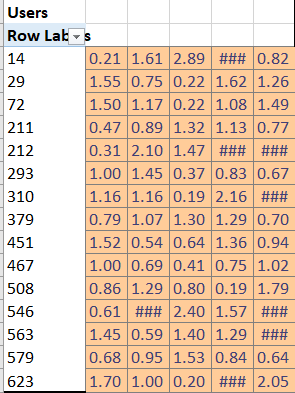

Now let's take our inital item parameters transposed (i X 5):
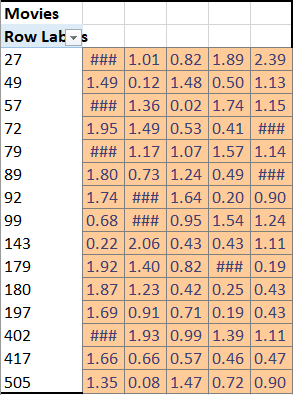

Now let's one-hot encode our users:


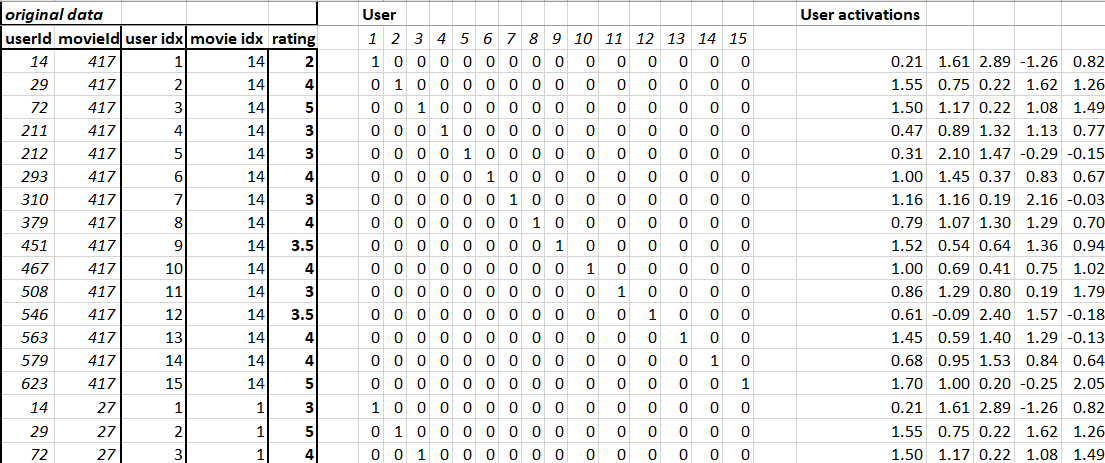

What happened above?
- In the left is that we have made our ratings a list of pairs adjacencys which means we have the following format: <**user, movie, rating**>.

- In the middle we have one hot encoded the users that have rated such movie.

- In the right we made the matrix multiplication of the 1-hot encoded matrix by the (u x 5) matrix shown at the beggining which has the weights we are currently using for the **users**. As we should notice the result in the row of the ith position in the 1-hot encoded matrix with a 1 is the same as such row in the original weight matrix.

Now let's see what happens if we do the same but now for the movies

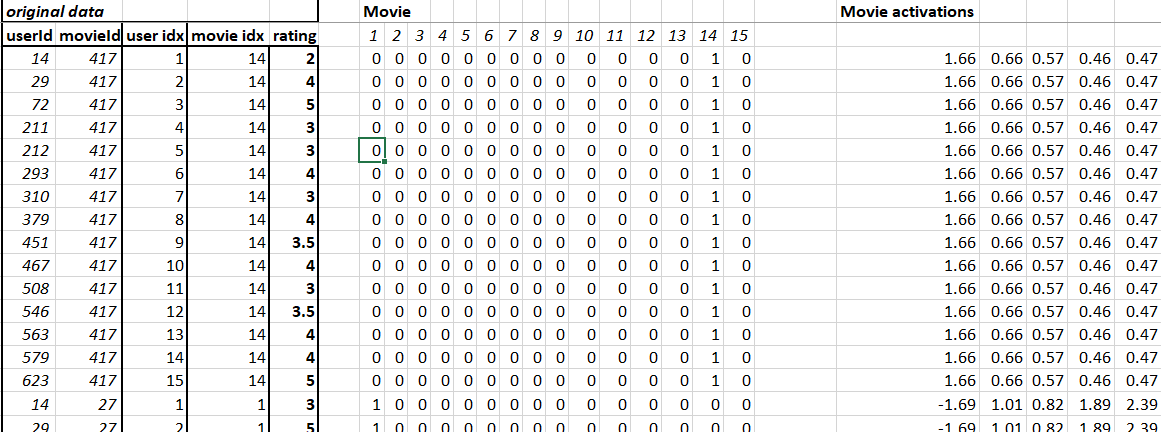

What happened above?
- In the left is that we have made our ratings a list of pairs adjacencys which means we have the following format: <**user, movie, rating**>.
- In the middle we have one hot encoded the movies that were rated by such user.
- In the right we made the matrix multiplication of the 1-hot encoded matrix by the (i x 5) matrix shown at the beggining which has the weights we are currently using for the **movies**. As we should notice the result in the row of the ith position in the 1-hot encoded matrix with a 1 is the same as such row in the original weight matrix.

Now let's calculate the predictions:

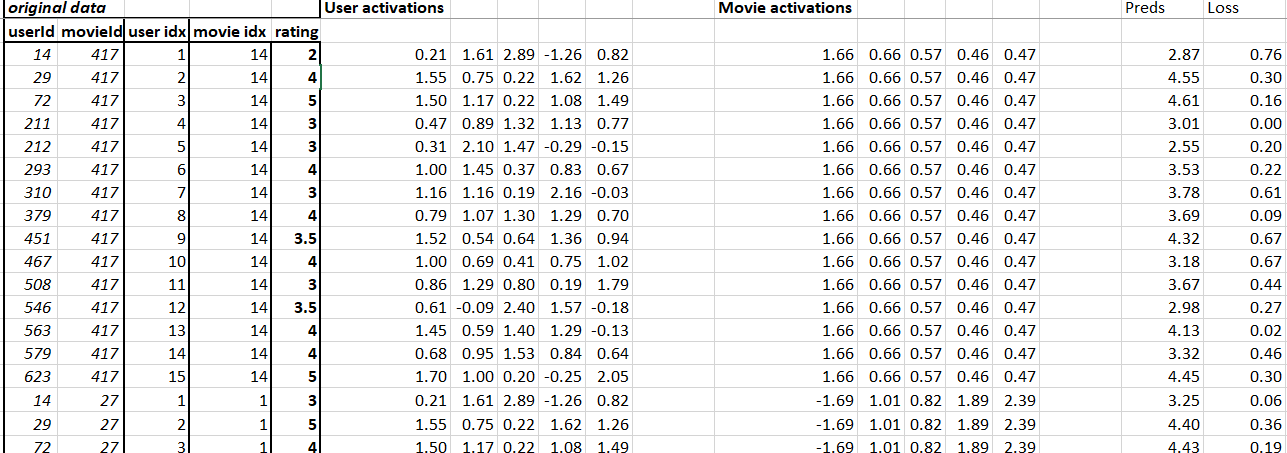

In the right of the picture the way we make the prediction is just by doing the **dot product** of both vectors (user activations) and (movie activations). And as we can see this will give us the prediction for the <**user, movie, rating**> and we can calculate it's loss function now.

And now, everythign we just this above is the input preprocessing, this 1-hot encoded matrices now will be our new **user inputs** and our new **movie inputs**.

Now the **Embedding** part here is that when doing the 1-hot enconded matrix multiplications with the respective weigths we are doing a lot of 0 mulitplications which aren't useful and time consuming. So what we do to create the activations instead of doing such multiplication is basically doing a row look up in our wigth matrix wich has the exact same effect as the multiplication we where previously doing but its so much faster. Therefore we should always use the array lookup version.


Therefore we have a specific way of saying I want to do a matrix multiplication by a 1-hot encoded matrix without ever actually creating by instead passing it a bunch of indexes and pretend they are one hot encoded and this is called an **embedding**.

Now something important to note is that when we multiply something by a 1-hot encoded matrix we ge this nice feature where the rows of our weight matrix appear only the idxs we pass our embedding with the ith row idx. So in other words we end up with this weight matrix where certaing rows of weight correspond to certain values of our input.


And that's very interesting since the only way we can calculate an output activation is by doing a dot product of 2 input vectors (u_weights and i_weights). That means that they kind of have to correspond with each other and somehow make sense and the only way this should work is if the u_weights represent features of personal taste and the i_weight represetn features of the movie. This underlying features that appear after doing the SGD are called **latent factors**.


Now somethign important is that biases also exist. Biases help us define something such as that there's a specific user who always likes movies a lot. And every user has a bias and every item has a bias.

## Back to Collaborative filtering -> movielens

### Imports and inital configuration

In [1]:
from fastai import *
from fastai.collab import *

In [2]:
user,item,title = 'userId','movieId','title'

In [3]:
path = Path('data/L5DL/ml-100k')

In [4]:
#! unzip data/L5DL/ml-100k.zip
path.ls()

FileNotFoundError: [Errno 2] No such file or directory: 'data/L5DL/ml-100k'

### Data

In [ ]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None, names=[user, item, 'rating', 'timestamp'])
ratings.head()

Note: The g's in the bellow chart represent a genere.

In [ ]:
movies = pd.read_csv(path/'u.item', delimiter='|', encoding='latin-1', header=None, names = [item, 'title', 'date', 'N', 'url', *[f'g{i}' for i in range(19)]])
movies.head()

In [ ]:
len(ratings)

Let's merge the movies to our ratings since we would like to see which exact movie we are talking about.

In [ ]:
rating_movie = ratings.merge(movies[[item, title]])
rating_movie.head()

In [ ]:
data = CollabDataBunch.from_df(rating_movie, seed=42, valid_pct=0.1, item_name=title)

In [ ]:
data.show_batch()

### Model

In [ ]:
y_range = [0, 5.5]

Here **y_range** is the range of values from our sigmoid at the end of the function. Something important to note is that the sigmoid will actually be assimptoting to 5 so to get more 'accurate' results we use a upperbound of 5.5 instead. This is usually a good practice.

Also there are 2 important things to note:

- n_factors: is actually the number of features we will be multiplying both for the user and the items. For this one we should try as much as we want so that we fin which one actually works best, in this case it was 40.

In [ ]:
learn = collab_learner(data, n_factors=40, y_range = y_range, wd=1e-1)

In [ ]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

About the learing rate:


5e-3 worked pretty well, we've seen 2 rules of thumb: 


- Silvans rule: Find the bottom and go 10x to the left of that.


- Jeremy's rule: Find the steepest slope but we can try 10x less or 10x more. In this case 10 less was more helpful.

In [ ]:
learn.fit_one_cycle(5, 5e-3)

As we can see from the results, we are doing quite better with this approach since the best they got as an RMSE is 0.91 but we are using MSE so 91**2 = .83 and we are getting .81 already.

So now we have 4 sets of cool result data: latent factors for users, latent factors for movies, and their biases.


Something cool is that to see which movies are cool, instead of looking at the average (which isn't that accurate after all since some users may be biased) we can take a look at the bias as an interesting way of saying which are the best movies.


Let's take a look into it:

In [ ]:
learn.save('dotprod')

### Interpretation

In [ ]:
learn.load('dotprod')

In [ ]:
learn.model

Let's get the movies with the most numbers of ratings:

In [ ]:
g = rating_movie.groupby(title)['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

In [ ]:
movie_bias = learn.bias(top_movies, is_item=True)
movie_bias.shape

Now for comparisson let's group titles by their mean rating.

In [ ]:
mean_ratings = rating_movie.groupby(title)['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies, movie_bias)]

Now we can see that this are overall not the greatest movies:

In [ ]:
item0 = lambda o:o[0]
sorted(movie_ratings, key=item0)[:15]

Now looking at the highest biases we see cool stuff about the movies:

In [ ]:
sorted(movie_ratings, key=item0, reverse=True)[:15]

Now let's check the weights:

In [ ]:
movie_w = learn.weight(top_movies, is_item=True)
movie_w.shape

Let's now squeeze into 3 this space of size 40 using principal component analisis so that we get the most (latent features) from here:

In [ ]:
movie_pca = movie_w.pca(3)
movie_pca.shape

About PCA it's important to know that taking layers and puting them through pca is very often a good idea cause bery often we have more activations in a layer than what we want and there's many reasons you want to play with it. Many times image similarity uses this technique to compare images.

In [ ]:
fac0, fac1, fac2 = movie_pca.t()
movie_comp = [(f, i) for f, i in zip(fac0, top_movies)]

Now let's get the top from the first factor in our movies, we don't kno exactly what it is but we know this might be somethign regarding the movie.

In [ ]:
sorted(movie_comp, key = itemgetter(0), reverse=True)[:10]

In [ ]:
sorted(movie_comp, key = itemgetter(0))[:10]

Let's plot the movies accoriding to theri feature 0 and feature 2

In [ ]:
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

## Weight decay

Weight decay is a type of regularization but, but what is regularization?

Well regularization is helps our model not overfit. Now there is a very common misconception that using a lot of **weights** makes our model overfit but that's not true. What happens if we have a lot of parameters but all of them are really small? 1e-9 wont really affect that much prehaps. So what we do is use **weight decay** to keep this parameters small. More parameters is often useful because it means more non-linearlities, more interactions and more curvy bits because real life is full of curvy bits but we don't want them to be more curvy than neccesary or more interactive than neccesary so that's where weight decay enters. So what we do is penalice complexity (parameters non-close to 0) and what we do is sum the squares of the parameters to the loss function, but maybe that number is huge, so huge that the best loss is actually setting all parameters to 0 which will be useles for our model so in order to make that not happen we use a scalar and multiply that by this sum. This is known in fastai as the **wd** parameter in our models (learners).


But wait, what value should we choose for wd?


Well generally it should be 1e-1. Since this is usually good. However it's important to note that the default is 1e-2. Why? Because there are rare ocasions in which we have too much weight decay no matter how much we train it just never quite fits well enough where as if we have to little weight decay it can still train well, we will just start to overfit eventualy and we should be careful of that.

### SGD

As we may remeber the way we where updating our weights was using SGD. using the formula
    
    Wt = Wt-1 - lr * dL/dWt-1
    
Where L represents a loss function (in this case MSE):

    L(x, w) = mse(model(x, w), y)
    
But now, using weight decay it will look like this

    L(x, w) = mse(model(x, w), y + wd * SUM(w^2)
    
So now, if we do the derivative what we endup having is this:

    Wt = Wt-1 - lr*(dl/dWt-1 + wd*Wt-1)

## MNIST Example (SGD, WD, Adam, Momentum, RMSProp, One Cycle)

So let's now use the above function but know with the MNIST dataset.

### Imports and inital configuration

In [8]:
%matplotlib inline
from fastai import *
from fastai.collab import *

In [16]:
path = Path('data/L5DL')
path.ls()

[PosixPath('data/L5DL/ml-100k.zip'),
 PosixPath('data/L5DL/mnist.pkl.gz'),
 PosixPath('data/L5DL/.ipynb_checkpoints')]

### Data

In [17]:
with gzip.open(path/'mnist.pkl.gz', 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

(50000, 784)

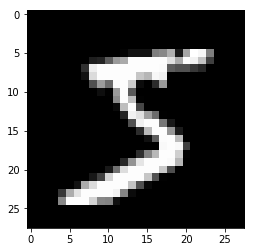

In [18]:
plt.imshow(x_train[0].reshape((28, 28)), cmap='gray')
x_train.shape

Currently they are numpy arrays so we map them to tensors.

In [19]:
x_train, y_train,x_valid,y_valid = map(torch.tensor, (x_train, y_train, x_valid, y_valid))
n, c = x_train.shape #total and activations 'c'
x_train.shape, y_train.min(), y_train.max()

(torch.Size([50000, 784]), tensor(0), tensor(9))

Now we will use pytorch to help us bild our SGD, let's configure the data. Note that we will use minibatches.


Something to note here is that we are using *TensorDataset* from pytorch which basically works as a list of tuples, the x and the y.

Then we use the fastai's databunch so it creates the *DataLoader* for our datasets which basically is an iterable list in which we can say "give me the next batch please" and it will do so.

In [20]:
bs = 64
train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)
data = DataBunch.create(train_ds, valid_ds, bs = bs)

In [21]:
x,y=next(iter(data.train_dl))
x.shape, y.shape

(torch.Size([64, 784]), torch.Size([64]))

Let's create our nn.Module from Pytorch which currently works as our model.


Something to note is that in the constructor we create a Linear layer which basically does de x@a + b thing for us.


Also, what forward is doing is calculating the result calculated by the linear layer.

In [22]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10, bias=True)
    def forward(self, xb): return self.lin(xb)

In [23]:
#model = Mnist_Logistic().cuda()
model = Mnist_Logistic()

In [24]:
model

Mnist_Logistic(
  (lin): Linear(in_features=784, out_features=10, bias=True)
)

In [25]:
model.lin

Linear(in_features=784, out_features=10, bias=True)

Let's see what happens when we call our model with a batch (this is basically calling the forward function for us.

In [26]:
model(x).shape

torch.Size([64, 10])

Perhaps one of the most *interesting* features from our model are the parameters which contains the weigths and biases we are using.

In [32]:
[p.shape for p in model.parameters()]

[torch.Size([10, 784]), torch.Size([10])]

In [33]:
lr = 2e-2

We can't really use MSE here but rather we will use CrossEntropy

In [23]:
loss_func = nn.CrossEntropyLoss()

Let's define our update function now. It's important to note that we are actually returning the loss.item() which is basically the loss as a python number.

In [24]:
def update(x, y, lr):
    wd = 1e-5
    y_hat = model(x)
    # weight decay
    w2 = 0.
    for p in model.parameters(): w2 += (p**2).sum()
    # add regular loss
    loss = loss_func(y_hat, y) + w2*wd
    loss.backward()
    with torch.no_grad():
        for p in model.parameters():
            p.sub_(lr * p.grad)
            p.grad.zero_()
    return loss.item()

In [25]:
losses = [update(x,y,lr) for x,y in data.train_dl]

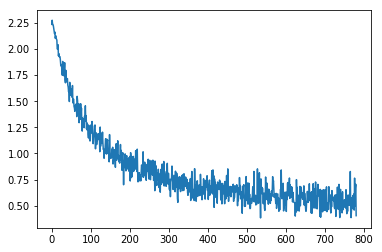

In [26]:
plt.plot(losses)

It's important to note we are not actually using learning rate anheling that's why there are some jumps in the graph where the learning rate is being miss adjusted.

Also we should note that basically when updating our weights we are subtracting our learining rate timed dL/dW which and when we get the derivative of the weight decay part we are doing the following:


    d wd * w2
    ---------  = 2 * wd * w
       dw
       
 which basically means we are subtracting lr * wd * w to our weights every time.

### Adam,  momenutm, rmsprop

So above we actualy created a neural networkd of 1 layer, let's now create one of 2 layers:

In [27]:
class Mnist_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(784, 50, bias=True)
        self.lin2 = nn.Linear(50, 10, bias=True)
        
    def forward(self, xb):
        x = self.lin1(xb)
        x = F.relu(x)
        return self.lin2(x)

In [28]:
#model = Mnist_NN().cuda()
model = Mnist_NN()

So now for the update function we will recall more on pytorch by using an optimizer, previously we used SGD but Adam works better because what Adam does that makes it better is 


- **Momentum:** What momentum does is speed up things in our model change and what we do is update by the derivative multiplied by a certain *ratio* and we look at the previous update and multiply it by (1-*ratio*) and we add that together. So in other words the update works using 10 percent the derivative and 90% is just the same direction we went last time.

        St = a*g + (1-a)*St-1
    As we may notice the formula above is an *exponentially weighted moving average* the reason why is that all **1-a** will keep multiplying and at the end we are considering all the previous momentums exponentially less evey time (but still considering) on the tth Step = St.
    
- **RMSPROP:** Is very similar to momenutm. What happens here is our momentum fomula changes to this:
        
        St = a*(g^2) + (1-a)*St-1
  So what this actually ends up meaning is an exponentially moving average of the gradient squared which is that if our gradient is very small then our step will consistently be a small number but if our gradient is high it will be a big number.
  
  This is actually veri interesting because now the update of our weigths is:
      
       W = W - lr*g/sqrt(St)
  Which means that when our gradient is consistently very small and not volatile let's take bigger jumps.
  
- **Momentum & RMSPROP (combined):** The obvious thing to do is combine both. This is what **Adam** does:

      St = a*g + (1-a)*St-1  -> exponentially moving average of the gradient
      Stdiv = a*(g^2) + (1-a)*Stdiv-1  -> exponentially moving average of the gradient squared
      
      W = W - lr*St/sqrt(Stdiv)
      
      
People often call this dynamic LR which isn't the case since we have to set it up actually. This optimizations are just trying to identify parameters that need to move faster or consistenly go in the same direction.

In [29]:
def update(x, y, lr):
    opt = optim.Adam(model.parameters(), lr)
    y_hat = model(x)
    loss = loss_func(y_hat, y)
    loss.backward()
    opt.step()
    opt.zero_grad()
    return loss.item()

In [47]:
optim.Adam??
# optim.SGD??
# x = Tensor([2])
# x.mul_(5).add_(3)

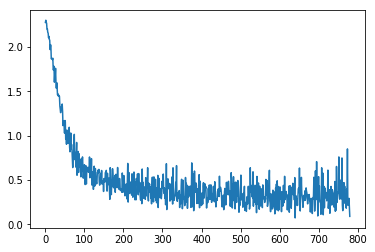

In [30]:
losses = [update(x, y, 0.001) for x,y in data.train_dl]
plt.plot(losses)

Now same thing but with learner:

In [33]:
learn = Learner(data, Mnist_NN(), loss_func = loss_func, metrics = accuracy)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


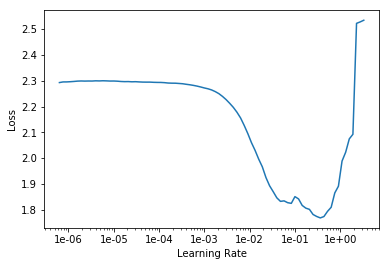

In [34]:
learn.lr_find()
learn.recorder.plot()

In [40]:
learn.fit_one_cycle(1, 3e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.159605,0.127038,0.964500,00:04


### One Cycle

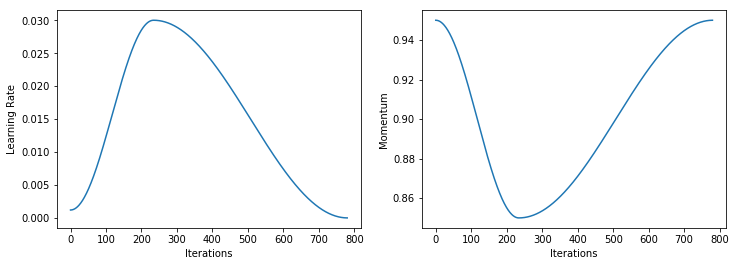

In [41]:
learn.recorder.plot_lr(show_moms=True)

What we are seeing above in the left is basically the learning rate per batch:
Which increases, then decreases about half the time.


Now something interesing is the momentum plot and as we can see every time our momentum is *inverse* to our learning rate and this is because if we have a small learingin rate and we keep going in the same direction we might as well go faster, but if our learning rate is big then we should not jump jump really far because we might go off. This combination is what we call **One-Cycle**.

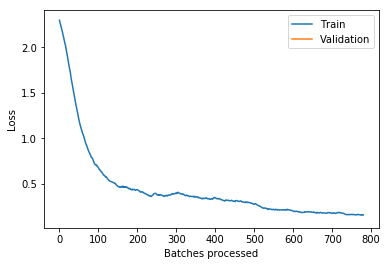

In [42]:
learn.recorder.plot_losses()

Something important to note is that fastai it looks smoother and the reason is that fastai calculates the expnentially weighted moving average of the losses for us. This thing about exponentially weighted stuff of stuff is particulary useful for a lot of stuff and one of those is to read the above chart.

## Crossentropy Loss and soft max

Crossentropy loss is a loss function designed for classifiers rather than regresors.
This penalizes 2 things:
- predicting the correct thing without confidence
- predicting the incorrect thing with confidence


The basic formula is:

    Sum of all:
    -obsA * LOF(predA) - obsB * LOG(predB)
    
However this only works if predA + predB = 1


So how do we guarantee this?

We use the correct activation function for our last layer which is: **softmax** which is an activation function where all activations:
- add 1
- are greater than 0
- all actiations are less than 1

The way we do this is by changing the ith activation to the following:

    Ai = e^(Ai) / SUM(e^(Ax))
    
    
So generally speaking we commonly want to use soft max as the activation function from our last layer and crossentropy loss as our loss function.


Something important to note is that pytorch will do them both for us when we use **nn.CrossentropyLoss()** it always does the ssoftmax for us inside the loss function.


Sometimes the predictions from our models might endup looking as rare numbers but this is likely just because we should apply the softmax to them for pure interpretaion since pytorch is already using it in the crossentropy loss function.